In [54]:
import numpy as np
from datetime import datetime
from core.trade_service.traders.base import BaseTrader
from core.analitics.basic_plots import to_pandas
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

In [26]:

def WMA(data, column, tf):
    """
        Wilder's Smoothing Technique
        
        WMAi = WMAi-1 + (Pricei - WMAi-1) / N

        where:
        WMAi - is the WMA value of the current period.
        WMAi-1 - is the value of the period immediately preceding the period being calculated,
        Pricei - is the source (Close or other) price of the current period.
        N - is the number of periods, over which the indicator is calculated.
        
    """
    moving_values = data.loc[:,column].values
    #counting initial NA
    count_na = 0
    for value in moving_values:
        if np.isnan(value):
            count_na += 1
        else:
            break
            
    wma = [np.NaN] * (count_na + tf -1)
    wma.append(np.mean(moving_values[count_na:count_na+tf]))     # First value simply sum of the first tf periods
    i = count_na+tf
    while(i < len(moving_values)):
        wma.append(wma[-1] + (moving_values[i] - wma[-1]) / tf)
        i += 1 
    return np.array(wma)

def EMA(data, column, tf):
    """
    Exponential Moving Averages
    """
    return data.loc[:, column].ewm(span=tf).mean()

def TR_single(row):
    """
    True value
    """
    return max(
        np.abs(row.high - row.low),
        np.abs(row.high - row.close_lag1),
        np.abs(row.close_lag1 - row.low)
    )

def TR(data):
    data.loc[:, 'close_lag1'] = data.close.shift()
    return data.apply(TR_single, axis=1)

def ATR(data, atr_tf=10):
    """
    Average True Value
    https://en.wikipedia.org/wiki/Average_true_range
    
    """
    data = data.copy()
    atr = [np.NaN] * (atr_tf -1)
    tr = TR(data)
    atr.append(np.mean(tr[:atr_tf])) # first values is the median of the first tf values
    i = atr_tf
    while i < len(data):
        atr.append(((atr[-1] * (atr_tf-1)) + tr[i])/atr_tf)
        i += 1
    return np.array(atr)

def KELT(data, atr_tf, ema_tf, band_width):
    """
    Keltner Channel
        https://en.wikipedia.org/wiki/Keltner_channel
        https://www.youtube.com/watch?v=7PDUdm7inRk
    """
    data = data.copy()
    atr = ATR(data, atr_tf)
    data.loc[:, 'ATR'] = atr
    ema = np.array(EMA(data, 'close', tf=ema_tf))
    return ema + band_width*atr, ema, ema - band_width*atr

def PDM_single(high_lag1, high, low_lag1, low):
    """
    positive directinal movement
    """
    if (high - high_lag1) > (low_lag1 - low):
        return (high - high_lag1)
    else:
        return 0
    
def NDM_single(high_lag1, high, low_lag1, low):
    """
    negative directinal movement
    """
    if (low_lag1 - low) > (high - high_lag1):
        return (low_lag1 - low)
    else:
        return 0
    

def PDM(data):
    """
    apply of positive directional movement
    """
    data.loc[:, 'high_lag1'] = data.high.shift()
    data.loc[:, 'low_lag1'] = data.low.shift()
    return data.apply(lambda row: PDM_single(row.high_lag1, row.high, row.low_lag1, row.low), axis=1)

def NDM(data):
    """
    apply of negative directional movement
    """
    data.loc[:, 'high_lag1'] = data.high.shift()
    data.loc[:, 'low_lag1'] = data.low.shift()
    return data.apply(lambda row: NDM_single(row.high_lag1, row.high, row.low_lag1, row.low), axis=1)

def PDI(data, mdi_tf=14):
    data = data.copy()
    data.loc[:,'PDM'] = PDM(data)
    return WMA(data, 'PDM', mdi_tf) * 100 / ATR(data,atr_tf=mdi_tf)

def NDI(data, mdi_tf=14):
    data = data.copy()
    data.loc[:,'NDM'] = NDM(data)
    return WMA(data, 'NDM', mdi_tf) * 100 / ATR(data,atr_tf=mdi_tf)

def ADX(data, adx_tf=14):
    """
    https://blog.quantinsti.com/adx-indicator-python/
    https://www.youtube.com/watch?v=laMart4lKcU
    
    Welles Wilder created the directional movement indicator and the ADX indicator to determine the direction as well as the strength of the trend. 
    According to Welles Wilder, the directional movement indicator is said to consist of the following components: the True Range, 
    Smoothed Plus Directional Indicator (+DI) and Smoothed Minus Directional Indicator (-DI).

    The ADX indicator is calculated as the smoothed average of the difference between the +DI indicator and the -DI indicator, 
    thus telling us the strength of the trend.

    The ADX indicator has a value between 0 and 100. It is generally agreed that if the ADX is above 25, it is a sign of a strong trend.
    """
    data = data.copy()
    data.loc[:,'PDI'] = PDI(data)
    data.loc[:,'NDI'] = NDI(data)
    data.loc[:, 'DX'] = np.abs((data.PDI - data.NDI)/(data.PDI + data.NDI))
    return WMA(data, 'DX', adx_tf) * 100

In [47]:
class ADX_Kelt_Trader(BaseTrader):
    def __init__(self,
                 mode='test',
                 symbol='BTCUSDT',
                 interval='1h',
                 on_investment: bool = False,
                 column_name: str = 'close',
                 kelt_atr: int = 14,
                 kelt_ema: int = 20,
                 kelt_bandwidth = 1,
                 adx_tf: int = 14,
                 start_time=datetime.fromisoformat('2020-01-01 00:00:00')
                 ):
        super().__init__(mode, symbol, interval, interval, start_time, on_investment)
        self.kelt_atr = kelt_atr
        self.kelt_ema = kelt_ema
        self.kelt_bandwidth = kelt_bandwidth
        self.adx_tf = adx_tf
        self.restart()

    def restart(self):
        self.max_period = max((self.kelt_atr, self.kelt_ema, self.adx_tf))
        return self

    def evaluate_buy(self, data):
        if len(data) > self.max_period:
            close = data.close.iloc[-1]
            open_ = data.open.iloc[-1]
            if  close > open_:
                sup, med, inf = KELT(data, self.kelt_atr, self.kelt_ema, self.kelt_bandwidth)
                last_sup = sup[-1]
                if close > last_sup:
                    pdi = PDI(data, self.adx_tf)[-1]
                    ndi = NDI(data, self.adx_tf)[-1]
                    if pdi > ndi:
                        return True
        return False

    def evaluate_sell(self, data):
        if len(data) > self.max_period:
            close = data.close.iloc[-1]
            open_ = data.open.iloc[-1]
            if  close < open_:
                sup, med, inf = KELT(data, self.kelt_atr, self.kelt_ema, self.kelt_bandwidth)
                last_med = med[-1]
                if close < last_med:
                    pdi = PDI(data, self.adx_tf)[-1]
                    ndi = NDI(data, self.adx_tf)[-1]
                    if pdi < ndi:
                        return True
        return False

    def plot_lines(self, month=None):
        result_pd = to_pandas(self.trade_record)
        data = self.data_mgr.get_data()
        if month:
            result_pd = result_pd[result_pd.start_datetime.dt.month == month]
            data = data[data.index.month == month]
        algo = data.close.plot(figsize=(20, 10), color='black')
        y_min, y_max = algo.get_ylim()
        for init, end, gain in zip(result_pd.start_datetime, result_pd.end_datetime, result_pd.gain):
            color = 'red' if gain < 0 else 'green'
            plt.fill_between(data[init:end].index, y_min, y_max, color=color, alpha=0.4)
            pl.text(end, y_min + (y_max - y_min) * 0.9, s=round(gain, 2), horizontalalignment='right')
            plt.title('Period gain: {}'.format(result_pd.gain.sum()))


In [69]:
model = ADX_Kelt_Trader(mode='sim', 
                        interval='1h',
                       start_time=datetime.fromisoformat('2021-01-01 00:00:00'))
model.data_mgr.end_time = datetime.fromisoformat('2021-03-01')
model.data_mgr._set_data()

In [70]:
model.evaluate()

In [71]:
model.score(1,1)

2.210554183696103

In [156]:
import pandas as pd
def price_based_loss_adjusted(row):
    if (row.end_price * 0.999 - row.start_price * 1.001) < 0:
        return (row.end_price * 0.999 - row.start_price * 1.001) * 100 / row.end_price
    else:
        return 0
    
def price_based_win_adjusted(row):
    if (row.end_price * 0.999 - row.start_price * 1.001) > 0:
        return (row.end_price * 0.999 - row.start_price * 1.001) * 100 / row.end_price
    else:
        return 0
    
def on_investment_percent_time(model):
    trade_record = model.trade_record
    data_mgr = model.data_mgr
    result_pd = pd.DataFrame(trade_record).T
    on_investment = np.sum([x.total_seconds() for x in (result_pd.end_datetime - result_pd.start_datetime)])
    total_time = (data_mgr.data_major.index.max() - model.data_mgr.start_time).total_seconds()
    return on_investment / total_time

In [157]:
on_investment_percent_time(model)


0.3250388802488336

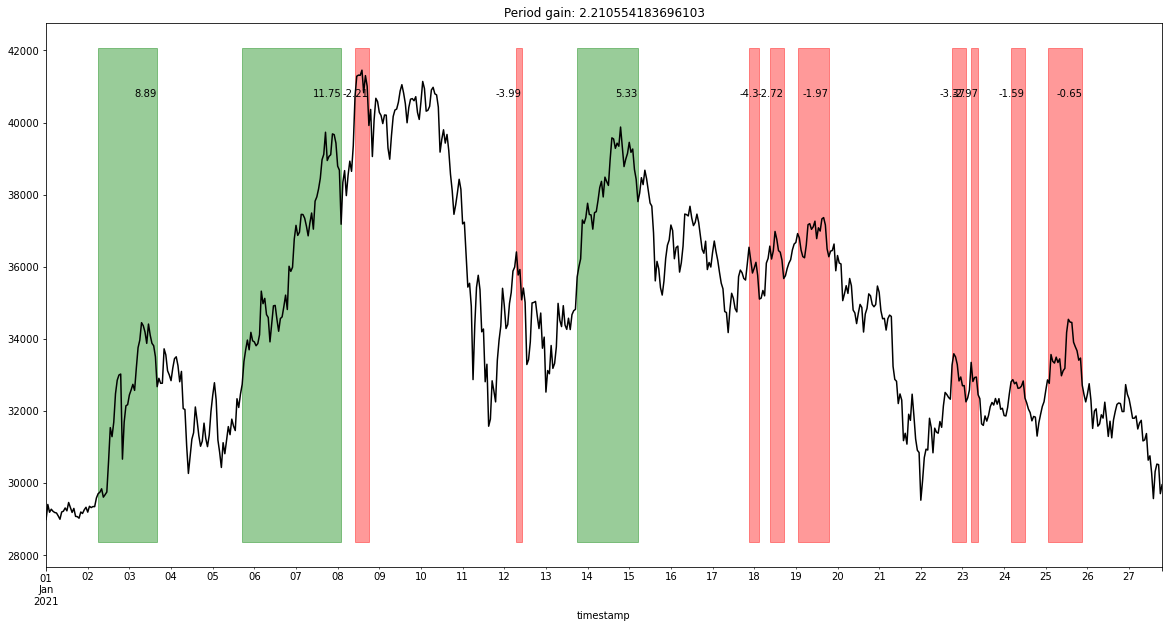

In [123]:
model.plot_lines()